In [1]:
"""
The code is divided into three blocks:
    Data Preprocessing
        Functions:
            handleTextCleaning(): For text cleaning purpose
            handleDataPreprocessing(): For processing dataset before feeding to the model
    
    Model Building
        Class:
            SentencePairDataset(): Prepares dataset for the dataloader
        Functions:
            handleModelTraining(): Trains the model
            handleModelEvaluation(): Validates the training
            handleModelTesting(): Tests the model
            handleTrainEvalModel(): Contains Train validation loop
            buildModel(): Encapsulate the entire process
    Result Analysis
"""
# I have tested using three different model:
# bert: 'bert-base-uncased'
# biobert: 'emilyalsentzer/Bio_ClinicalBERT'
# electra: 'google/electra-base-discriminator'
# each functions and it's working has been described in it's respective cell
               
            

'\nThe code is divided into three blocks:\n    Data Preprocessing\n        Functions:\n            handleTextCleaning(): For text cleaning purpose\n            handleDataPreprocessing(): For processing dataset before feeding to the model\n    \n    Model Building\n        Class:\n            SentencePairDataset(): Prepares dataset for the dataloader\n        Functions:\n            handleModelTraining(): Trains the model\n            handleModelEvaluation(): Validates the training\n            handleModelTesting(): Tests the model\n            handleTrainEvalModel(): Contains Train validation loop\n            buildModel(): Encapsulate the entire process\n    Result Analysis\n'

In [1]:
# Do not run this cell if you have installed the environment or have already installed the packages
# !pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.8 MB/s eta 0:00:00


In [3]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm.notebook import tqdm
import utils
import torch
import logging
import re
import sys
import nltk
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
logger = logging.getLogger('my_logger')
logger.setLevel(logging.INFO)

# removing all existing handlers
for handler in logger.handlers[:]:
    logger.removeHandler(handler)

# creating handlers
stream_handler = logging.StreamHandler(sys.stdout)
file_handler = logging.FileHandler(f'../logs/falcon_logfile.log')

# creating formatters
formatter = logging.Formatter('%(message)s')
stream_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)

# adding handlers to the logger
logger.addHandler(stream_handler)
logger.addHandler(file_handler)
logger.propagate = False

logger.info("Starting...")

Starting...


In [5]:
class SentencePairDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        data = self.dataframe.iloc[idx]
        id=data['id']
        sentence1 = data['sentence1']
        sentence2 = data['sentence2']
        label = data['label']
        inputs = self.tokenizer.encode_plus(
            sentence1, sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'id': id,
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Data Preprocessing

In [6]:
def handleTextCleaning(text):
    """
    A function to clean text data, preserving biomedical terms.

    Parameters:
    - text (str): The text to be cleaned.

    Returns:
    - str: The cleaned text.
    """
    # Converting text to lowercase (optional, may not be ideal for case-sensitive terms)
    text = text.lower()

    # Removing newline characters
    text = text.replace('\n', ' ')
    text = text.replace('_', ' ')

    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [7]:
def handleDataPreprocessing(data_path):
    """
    Preprocesses data before feeding to the model: focusing on text cleaning and dataset splitting.

    The function performs several key operations:
    - Reads data from the specified CSV file.
    - Extracts and retains important columns relevant to the task: 'PREDICATION_ID', 'PREDICATE', 'SUBJECT_TEXT', 'OBJECT_TEXT', 'SENTENCE', and 'LABEL'.
    - Adds new columns to the DataFrame for holding cleaned text data: 'PREDICATION', 'PREDICATION_clean', and 'SENTENCE_clean'.
    - Constructs the 'PREDICATION' column by concatenating 'SUBJECT_TEXT', 'PREDICATE', and 'OBJECT_TEXT'.
    - Cleans text data in 'PREDICATION' and 'SENTENCE' columns using the 'handleTextCleaning' function, and stores the results in 'PREDICATION_clean' and 'SENTENCE_clean'.
    - Converts the 'LABEL' column into a binary format, mapping 'y' to 1 and 'n' to 0.
    - Selects and renames columns for consistency and clarity, resulting in a DataFrame with 'id', 'sentence1', 'sentence2', and 'label' columns.
    - Splits the sampled data into training, development, and test sets.

    Parameters:
    - data_path (str): A string representing the path to the raw CSV data file that needs to be preprocessed.

    Returns:
    - tuple:    A tuple containing three DataFrames (train_df, dev_df, test_df), representing the training, development, and test sets, respectively.
                Each DataFrame includes cleaned and processed text data along with the respective 'split' label indicating its set designation.
    """

    data=pd.read_csv(data_path)
    print(data.head())
    # extracting relevant columns
    data=data[["PREDICATION_ID","PREDICATE","SUBJECT_TEXT","OBJECT_TEXT","SENTENCE","LABEL"]]
    print(data.head())
    # inserting new 'PREDICATION'(for storing concatenated string <'SUBJECT_TEXT' + 'PREDICATE' + 'OBJECT_TEXT'>),
    # 'PREDICATION_clean' and 'SENTENCE_clean' columns for storing cleaned predication and sentences
    data.insert(loc=4, column='PREDICATION', value=0)
    data.insert(loc=5, column='PREDICATION_clean', value=0)
    data.insert(loc=7, column='SENTENCE_clean', value=0)
    for i in tqdm(range(0,len(data))):
        #concatenating 'SUBJECT_TEXT', 'PREDICATE', 'OBJECT_TEXT' and saving into "PREDICATION" column
        data.iloc[i,4]=data.iloc[i,2]+" "+data.iloc[i,1]+" "+data.iloc[i,3]
        #cleaning both "PREDICATION" and "SENTENCE" column
        data.iloc[i,5]=handleTextCleaning(data.iloc[i,4])
        data.iloc[i,7]=handleTextCleaning(data.iloc[i,6])
    # converting labels into binary format
    data['LABEL'] = data['LABEL'].map({'y': 1, 'n': 0})
    all_dataset=data[["PREDICATION_ID","SENTENCE_clean","PREDICATION_clean", "LABEL"]]
    # renaming and taking columns ('id', 'sentence1', 'sentence2', and 'label')
    all_dataset=all_dataset.rename(columns={"PREDICATION_ID":"id", "SENTENCE_clean":"sentence1", "PREDICATION_clean":"sentence2", "LABEL":"label"})
    all_dataset=all_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    # splitting full dataset into train, valid and test set having 0.6:0.2:0.2 ratio
    train_df, temp_df = train_test_split(all_dataset, test_size=0.4, random_state=42, stratify=all_dataset['label'])
    dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    train_df['split'] = 'train'
    dev_df['split'] = 'dev'
    test_df['split'] = 'test'

    # Concatenate the datasets back together
    df = pd.concat([train_df, dev_df, test_df])
    print(df.head())
    logger.info(f"train,eval,test splits: {train_df.shape[0]},{ dev_df.shape[0]},{test_df.shape[0]}")
    return train_df, dev_df, test_df

Model Building

In [8]:
# Training Function
def handleModelTraining(model, data_loader, optimizer, scheduler, device, n_samples):
    """
    Trains a machine learning model using the provided data, optimizer, and scheduler.

    This function goes through the following steps:
    - Sets the model to training mode.
    - Iterates over batches of data in 'data_loader':
        -- Moves input data and labels to the specified 'device' (e.g., GPU or CPU).
        -- Passes the input data to the model and computes the output.
        -- Calculates the loss between the model output and the true labels.
        -- Performs backpropagation to compute gradients.
        -- Updates model parameters using the optimizer.
        -- Updates the learning rate using the scheduler.
        -- Resets gradients in the optimizer for the next iteration.

    Parameters:
    - model (torch.nn.Module): The model to be trained.
    - data_loader (DataLoader): An iterable DataLoader containing the training data.
    - optimizer: The optimization algorithm used to update the model's weights.
    - scheduler: Learning rate scheduler to adjust the learning rate during training.
    - device (torch.device): The device (e.g., 'cuda', 'cpu') on which to perform computations.
    - n_samples (int): Total number of samples in the dataset.

    Returns:
    - tuple: A tuple containing the training accuracy and the average loss per example.
    """
    model = model.train()
    losses = []
    correct_predictions = 0
    # iterating over batches of data in 'data_loader'
    for batch in tqdm(data_loader):
        # moving input_ids, attention_mask, labels to available device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # getting output from the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        # performing backpropagation
        loss.backward()
        #  clipping gradients to prevent exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        #updating optimizer and scheduler
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_samples, np.mean(losses)


In [9]:
# Validation Function
def handleModelEvaluation(model, data_loader, device, n_samples):
    """
    Evaluates the model on the validation dataset.

    This function performs model evaluation by calculating loss, accuracy, AUC (Area Under Curve),
    and generating a confusion matrix, sensitivity, specificity, and classification report.
    It operates in a no-gradient context to optimize memory and computation during evaluation.

    Steps performed:
    - Sets the model to evaluation mode.
    - Iterates over the data_loader to process data in batches.
        -- Moves the input data and labels to the specified device (e.g., GPU).
        -- Computes the model's outputs based on the input data.
        -- Calculates and accumulates the loss.
        -- Extracts logits from the model outputs and calculates the probabilities using softmax.
    - Determines the predicted labels and counts the number of correct predictions.
    - Stores all results (loss, predictions, probabilities, true labels)
    - Computes the AUC score using true labels and predicted probabilities.
    - Generates and logs the confusion matrix, sensitivity (True Positive Rate) and specificity (True Negative Rate).
    - Generates and logs a classification report containing precision, recall, and F1-score.
    - Returns the accuracy, average loss, AUC, sensitivity, and specificity.

    Parameters:
    - model (torch.nn.Module): The model to be evaluated.
    - data_loader (DataLoader): DataLoader object that provides batches of data for evaluation.
    - device (torch.device): The computing device (e.g., 'cuda', 'cpu') on which the model runs.
    - n_samples (int): The total number of samples in the validation dataset.

    Returns:
    - tuple: A tuple containing the accuracy, average loss, AUC, sensitivity, and specificity of the model on the evaluation dataset.
    """

    # Setting the model to evaluation mode.
    model = model.eval()
    losses = []
    correct_predictions = 0
    true_labels = []
    predictions_labels = []
    probabilities = []
    # disabling gradient calculation
    with torch.no_grad():
        # iterating over batches of data in 'data_loader'
        for batch in tqdm(data_loader):
            # moving input_ids, attention_mask, labels to available device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # getting output from the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            # extracting raw probabilities for calculating AUC
            prob = F.softmax(logits, dim=1)
            # computing predicted label
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            predictions_labels.extend(preds.cpu().numpy())
            probabilities.extend(prob.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    true_labels = np.array(true_labels)
    predictions_labels = np.array(predictions_labels)
    # taking the probability of the positive class
    proba = np.array(probabilities)[:, 1]
    # calculating and logging AUC
    auc = roc_auc_score(true_labels, proba)
    logger.info("----- Validation Results -----")
    logger.info(f"AUC: {auc}")
    # calculating and logging Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predictions_labels)
    logger.info(f"Confusion Matrix:\n {conf_matrix}")
    TN, FP, FN, TP = conf_matrix.ravel()

    # calculating Sensitivity, Specificity and Classification Report
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    class_report = classification_report(true_labels, predictions_labels)
    logger.info(class_report)
    return correct_predictions.double() / n_samples, np.mean(losses), auc, f1_score, sensitivity, specificity, precision

In [10]:
def handleModelTesting(set, model_name, model, test_df, device):
    """
    Test the model on the test dataset and logs performance metrics.

    This function performs the following steps:
    - Sets the model to evaluation mode.
    - Creates a dataset and dataloader for the test data.
    - Iterates over the test dataset in batches, performing predictions with the model.
        -- Stores batch ids, predicted labels, probabilities, and true labels.
    - Calculates various performance metrics, including AUC, accuracy, sensitivity, specificity, and confusion matrix.
    - Creates a DataFrame with test results, including true labels, predictions, and probabilities for both classes.
    - Saves the test results DataFrame to a CSV file for further analysis.

    Parameters:
    - set (int): An identifier for the test set, used in the filename of the saved results.
    - model_name (str): The name of the model used for loading the tokenizer.
    - model (torch.nn.Module): The PyTorch model to be evaluated.
    - test_df (pd.DataFrame): A DataFrame containing the test data.
    - device (torch.device): The PyTorch device (e.g., 'cuda' or 'cpu') to which the model and data are moved.

    Returns:
    - tuple: A tuple containing the calculated metrics: accuracy, AUC, sensitivity, and specificity.
    """

    # setting the model to evaluation mode
    model = model.eval()
    tokenizer = AutoTokenizer.from_pretrained("Rocketknight1/falcon-rw-1b")

    test_dataset = SentencePairDataset(test_df, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    ids=[]
    true_labels = []
    predictions_labels = []
    probabilities = []
    # disabling gradient calculation
    with torch.no_grad():
        # iterating over batches of data in 'data_loader'
        for batch in test_loader:
            # moving input_ids, attention_mask, labels to available device
            id=batch['id']
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # getting output from the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            logits = outputs.logits
            # extracting raw probabilities for calculating AUC
            prob = F.softmax(logits, dim=1)
            _, preds = torch.max(logits, dim=1)
            # also preserving id to track the output result for future analysis
            ids.extend(id)
            predictions_labels.extend(preds.cpu().numpy())
            probabilities.extend(prob.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    true_labels = np.array(true_labels)
    proba = np.array(probabilities)[:, 1]
    predictions_labels = np.array(predictions_labels)
    # calculating and logging AUC
    auc = roc_auc_score(true_labels, proba)
    logger.info("----- Test Results -----")
    logger.info(f"AUC: {auc}")
    # calculate Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predictions_labels)

    TN, FP, FN, TP = conf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    logger.info(f"Accuracy: {accuracy}")
    logger.info(f"Confusion Matrix:\n {conf_matrix}")
    # calculating Sensitivity and Specificity
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision= TP / (TP + FP)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    # calculate Classification Report
    class_report = classification_report(true_labels, predictions_labels)
    logger.info(class_report)
    # Saving result of each run for future analysis
    test_result_df=pd.DataFrame({"id":ids,
                                 "y_true":true_labels,
                                 "y_pred": predictions_labels,
                                 "y_pred_0":np.array(probabilities)[:, 0],
                                 "y_pred_1":np.array(probabilities)[:, 1]
                                 })
    test_result_df.to_csv(f"../results/{model_name}_test_set_{set}_results.csv", index=False)
    return accuracy, auc, f1_score, sensitivity, specificity, precision

In [11]:
def handleTrainEvalModel(train_df, valid_df, model_name, num_epoch, batch_size, lr):
    """
    Trains and evaluates the model.

    This function performs several key steps:

    - Initializes the tokenizer and datasets for training and validation using the BERT model.
    - Creates DataLoader objects for the training and validation datasets with specified batch sizes.
    - Initializes the BERT model for our semrep task.
    - Sets up the model to use GPU if available, and configures multi-GPU training if multiple GPUs are detected.
    - Implements the optimizer (AdamW) a learning rate scheduler with a linear warm-up phase.
    - Trains the model for the specified number of epochs, logging training accuracy and loss.
    - Evaluates the model on the validation set after each epoch, logging accuracy, loss, AUC, sensitivity, and specificity.
    - Saves the model with the best validation loss observed during training.
    - Logs the best loss and the epoch at which it was found.

    Parameters:
    - train_df (DataFrame): The training data as a Pandas DataFrame.
    - valid_df (DataFrame): The validation data as a Pandas DataFrame.
    - model_name (str): The name of the pre-trained BERT model to be used.
    - num_epoch (int): The number of epochs for training the model.
    - batch_size (int): The batch size for training and validation.
    - lr (float): The learning rate for the optimizer.

    Returns:
    - tuple: A tuple containing the best validation accuracy, loss, AUC, epoch number, sensitivity, and specificity.
    """
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)


    num_gpus=torch.cuda.device_count()
    # defining tokenizer for processing model input
    tokenizer = AutoTokenizer.from_pretrained("Rocketknight1/falcon-rw-1b")
    # SentencePairDataset is a customized class of Dataset object which not only handle tokenization of sentence pair
    # but also retains id column to track them for further analysis
    train_dataset = SentencePairDataset(train_df, tokenizer)
    val_dataset = SentencePairDataset(valid_df, tokenizer)

    # defining training and validation dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    #defining our pretrained model
    model = AutoModelForSequenceClassification.from_pretrained("Rocketknight1/falcon-rw-1b", num_labels=2)

    # moving model to available device
    device=torch.device("cpu")
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model = model.to(device)

    # parallel processing for speeding up the training process
    if torch.cuda.device_count() > 1:
        logger.info(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
        devices = [torch.device(f"cuda:{i}") for i in range(torch.cuda.device_count())]


    criterion = nn.CrossEntropyLoss() # can handle both binary and multiclass classification
    # defining the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * num_epoch
    # creating the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0.1*total_steps,
                                                num_training_steps=total_steps)
    epochs=num_epoch
    best_loss=1e5
    # training and evaluation loop
    for epoch in range(epochs):
        logger.info(f'Epoch {epoch + 1}/{epochs}')
        logger.info('-' * 10)

        # handleModelTraining function trains the model on entire trining set and returns trainng accuracy and loss
        train_acc, train_loss = handleModelTraining(
            model,
            train_loader,
            optimizer,
            scheduler,
            device,
            len(train_dataset)
        )

        logger.info(f'Train loss {train_loss} accuracy {train_acc}')
        # handleModelEvaluation function evaluates the model on validation set and returns validation accuracy,loss and other metrices
        val_acc, val_loss, val_auc,val_f1, sensitivity, specificity, precision = handleModelEvaluation(
            model,
            val_loader,
            device,
            len(val_dataset)
        )
        model.train()

        # always looking for the least loss. saving the validation result if the loss is lower than the previous
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch+1
            best_acc= val_acc
            best_auc= val_auc
            best_f1= val_f1
            best_sensitivity = sensitivity
            best_specificity = specificity
            best_precision= precision
            logger.info(f"best_loss till now: {best_loss}")
            logger.info("saving the model....")
            # saving the model for testing it on test data
            torch.save(model,f"../models/semrep_simple_{model_name}_model")
        logger.info(f'Val loss {val_loss}, accuracy {val_acc}')
    logger.info(f"Best loss {best_loss} found at epoch {best_epoch}")
    return best_acc, best_auc,best_f1, best_loss, best_epoch, best_sensitivity, best_specificity, best_precision

In [12]:
def buildModel(model_name, lr, num_epoch, batch_size, num_runs, train_df, valid_df, test_df):
    """
    Trains, validates and tests the model across multiple runs,
    tracking and storing performance metrics on both validation and test datasets from each run.
    It executes the following steps:
    - Initializes dictionaries ('metrics_best' and 'metrics_test') to store performance metrics
       like Accuracy, AUC, Sensitivity, Specificity, Loss, and Epoch number.
    - Iterates over the specified number of runs ('num_runs'), logging the run number for tracking.
        --  In each run, it trains and validates the model using the 'handleTrainEvalModel' function
        --  Stores the best validation metrics from each run in 'metrics_best'.
        --  Loads the trained model and evaluates it on the test dataset using 'handleModelTesting'.
        --  Appends test metrics to 'metrics_test'.
    - After all runs, compiles the collected metrics into DataFrames ('val_result_df' and 'test_result_df')
    - Saves and returns these DataFrames to CSV files for later analysis.


    Parameters:
    - model_name (str): Name of the model to be used.
    - lr (float): Learning rate for the model training.
    - num_epoch (int): Number of epochs for each training run.
    - batch_size (int): Batch size for training the model.
    - num_runs (int): Number of runs for training and evaluation.
    - train_df (DataFrame): DataFrame containing the training data.
    - valid_df (DataFrame): DataFrame containing the validation data.
    - test_df (DataFrame): DataFrame containing the test data.

    Returns:
    - tuple: A tuple containing two DataFrames (val_result_df, test_result_df), representing the
             validation and test results across all runs.
    """
    # initializing dictionaries for for storing validation and test metrics
    metrics_best = {
        "Accuracy": [],
        "AUC": [],
        "F1":[],
        "Loss": [],
        "Epoch": [],
        "Sensitivity": [],
        "Specificity": [],
        "Precision": []
    }

    metrics_test = {
        "Accuracy": [],
        "AUC": [],
        "F1":[],
        "Sensitivity": [],
        "Specificity": [],
        "Precision": []
    }

    # iterating through multiple runs
    for i in tqdm(range(num_runs)):
        logger.info(f"########## RUN {i} ##########")

        # training and validation
        best_metrics = handleTrainEvalModel(train_df, valid_df, model_name, num_epoch, batch_size, lr)
        for metric_name, value in zip(metrics_best.keys(), best_metrics):
            metrics_best[metric_name].append(value.cpu().numpy() if metric_name == "Accuracy" else value)

        # loading model and running test
        loaded_model = torch.load(f"../models/semrep_simple_{model_name}_model")
        loaded_model.to('cuda' if torch.cuda.is_available() else 'cpu')

        test_metrics = handleModelTesting(i, model_name, loaded_model, test_df, loaded_model.device)
        for metric_name, value in zip(metrics_test.keys(), test_metrics):
            metrics_test[metric_name].append(value)

    # creating and saving result dataframes
    val_result_df = pd.DataFrame(metrics_best)
    test_result_df = pd.DataFrame(metrics_test)

    val_result_df.to_csv(f"../results/val_{model_name}_results.csv")
    test_result_df.to_csv(f"../results/test_{model_name}_results.csv")

    return val_result_df, test_result_df

In [13]:
MODEL_NAME="Rocketknight1/falcon-rw-1b"
KEY="falcon"
LR=2e-5
NUM_EPOCHS=6
BATCH_SIZE=16
NUM_RUNS=2
DATA_PATH="../data/substance_interactions.csv"

train_df, val_df, test_df=handleDataPreprocessing(DATA_PATH)
# train_df, val_df, test_df=handleDataPreparation(df)
val_result_df, test_result_df=buildModel(KEY,
                                         LR,
                                         NUM_EPOCHS,
                                         BATCH_SIZE,
                                         NUM_RUNS,
                                         train_df,
                                         val_df,
                                         test_df
                                         )


  PREDICATION_ID      PMID       PREDICATE INDICATOR_TYPE  \
0          P3100   6499897  INTERACTS_WITH            NOM   
1          P3101   8369307        INHIBITS           VERB   
2          P3102   3711333        INHIBITS           VERB   
3          P3103  11742534  INTERACTS_WITH            NOM   
4          P3104    244385      STIMULATES            ADJ   

   PREDICATE_START_INDEX  PREDICATE_END_INDEX                 SUBJECT_TEXT  \
0                   1298                 1304                           SA   
1                    890                  899                          rHF   
2                   1527                 1534                    alkaloids   
3                    746                  753                  amino acids   
4                    410                  419  Neutral       endopeptidase   

  SUBJECT_SEMTYPE  SUBJECT_START_INDEX  SUBJECT_END_INDEX  ...  \
0            orch                 1235               1237  ...   
1            aapp               

  0%|          | 0/3000 [00:00<?, ?it/s]

         id                                          sentence1  \
2473  P3175  if the abuse potential of tranquilizers, and p...   
311   P4492  insulin-like growth factors (igfs) are bound t...   
504   P3321  competitive binding assays were performed on n...   
2001  P5682  [studies on the problem of resistance to oxyto...   
2017  P4922  these results, by showing that il-2 exerts an ...   

                                              sentence2  label  split  
2473                   alcohol stimulates tranquilizers      0  train  
311   insulin-like growth factors interacts with bin...      1  train  
504                            igf-i stimulates insulin      0  train  
2001                      fluothane stimulates oxytocin      0  train  
2017                            il-2 inhibits cytokines      0  train  
train,eval,test splits: 1800,600,600


  0%|          | 0/5 [00:00<?, ?it/s]

########## RUN 0 ##########


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.6674763871505197 accuracy 0.5805555555555556


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.7549771658906418
Confusion Matrix:
 [[189  90]
 [ 94 227]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       279
           1       0.72      0.71      0.71       321

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.69      0.69      0.69       600

best_loss till now: 0.5952181220054626
saving the model....
Val loss 0.5952181220054626, accuracy 0.6933333333333334
Epoch 2/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.5267910097552612 accuracy 0.7322222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8580265523286325
Confusion Matrix:
 [[194  85]
 [ 49 272]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       279
           1       0.76      0.85      0.80       321

    accuracy                           0.78       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.78      0.78      0.77       600

best_loss till now: 0.48479068671402176
saving the model....
Val loss 0.48479068671402176, accuracy 0.7766666666666667
Epoch 3/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.35081033553697366 accuracy 0.8594444444444445


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.861376299422727
Confusion Matrix:
 [[171 108]
 [ 29 292]]
              precision    recall  f1-score   support

           0       0.85      0.61      0.71       279
           1       0.73      0.91      0.81       321

    accuracy                           0.77       600
   macro avg       0.79      0.76      0.76       600
weighted avg       0.79      0.77      0.77       600

Val loss 0.5591426099601545, accuracy 0.7716666666666667
Epoch 4/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.24848312139511108 accuracy 0.9138888888888889


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8524213088578478
Confusion Matrix:
 [[173 106]
 [ 27 294]]
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       279
           1       0.73      0.92      0.82       321

    accuracy                           0.78       600
   macro avg       0.80      0.77      0.77       600
weighted avg       0.80      0.78      0.77       600

Val loss 0.6565490098376023, accuracy 0.7783333333333334
Epoch 5/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.14741776781403912 accuracy 0.9561111111111111


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8632186603244787
Confusion Matrix:
 [[208  71]
 [ 54 267]]
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       279
           1       0.79      0.83      0.81       321

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600

Val loss 0.6886503225878665, accuracy 0.7916666666666667
Epoch 6/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.11808421653983868 accuracy 0.9677777777777777


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.847608838865999
Confusion Matrix:
 [[174 105]
 [ 28 293]]
              precision    recall  f1-score   support

           0       0.86      0.62      0.72       279
           1       0.74      0.91      0.82       321

    accuracy                           0.78       600
   macro avg       0.80      0.77      0.77       600
weighted avg       0.79      0.78      0.77       600

Val loss 0.8158139791339636, accuracy 0.7783333333333334
Best loss 0.48479068671402176 found at epoch 2
----- Test Results -----
AUC: 0.865529985819404
Accuracy: 0.755
Confusion Matrix:
 [[181  98]
 [ 49 272]]
              precision    recall  f1-score   support

           0       0.79      0.65      0.71       279
           1       0.74      0.85      0.79       321

    accuracy                           0.76       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.76      0.76      0.75       600

########## RUN 1 ##########


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.6587983997522202 accuracy 0.6066666666666667


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.7837626592525597
Confusion Matrix:
 [[168 111]
 [ 62 259]]
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       279
           1       0.70      0.81      0.75       321

    accuracy                           0.71       600
   macro avg       0.72      0.70      0.70       600
weighted avg       0.71      0.71      0.71       600

best_loss till now: 0.5738929729712637
saving the model....
Val loss 0.5738929729712637, accuracy 0.7116666666666667
Epoch 2/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.5122867023522875 accuracy 0.7627777777777778


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8618452640159001
Confusion Matrix:
 [[142 137]
 [ 19 302]]
              precision    recall  f1-score   support

           0       0.88      0.51      0.65       279
           1       0.69      0.94      0.79       321

    accuracy                           0.74       600
   macro avg       0.78      0.72      0.72       600
weighted avg       0.78      0.74      0.73       600

best_loss till now: 0.5597338237260517
saving the model....
Val loss 0.5597338237260517, accuracy 0.7400000000000001
Epoch 3/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.33692739495133933 accuracy 0.87


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8760370258712133
Confusion Matrix:
 [[195  84]
 [ 43 278]]
              precision    recall  f1-score   support

           0       0.82      0.70      0.75       279
           1       0.77      0.87      0.81       321

    accuracy                           0.79       600
   macro avg       0.79      0.78      0.78       600
weighted avg       0.79      0.79      0.79       600

best_loss till now: 0.4935649951037608
saving the model....
Val loss 0.4935649951037608, accuracy 0.7883333333333333
Epoch 4/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.21830379705777211 accuracy 0.9272222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8749706897129268
Confusion Matrix:
 [[179 100]
 [ 29 292]]
              precision    recall  f1-score   support

           0       0.86      0.64      0.74       279
           1       0.74      0.91      0.82       321

    accuracy                           0.79       600
   macro avg       0.80      0.78      0.78       600
weighted avg       0.80      0.79      0.78       600

Val loss 0.6225055075789753, accuracy 0.785
Epoch 5/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.12596458621916518 accuracy 0.9627777777777777


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8712915508212463
Confusion Matrix:
 [[185  94]
 [ 31 290]]
              precision    recall  f1-score   support

           0       0.86      0.66      0.75       279
           1       0.76      0.90      0.82       321

    accuracy                           0.79       600
   macro avg       0.81      0.78      0.79       600
weighted avg       0.80      0.79      0.79       600

Val loss 0.7450266574558458, accuracy 0.7916666666666667
Epoch 6/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.08640503367425593 accuracy 0.9744444444444444


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8626268716711888
Confusion Matrix:
 [[181  98]
 [ 25 296]]
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       279
           1       0.75      0.92      0.83       321

    accuracy                           0.80       600
   macro avg       0.81      0.79      0.79       600
weighted avg       0.81      0.80      0.79       600

Val loss 0.7953127120670519, accuracy 0.795
Best loss 0.4935649951037608 found at epoch 3
----- Test Results -----
AUC: 0.8955102223115488
Accuracy: 0.8016666666666666
Confusion Matrix:
 [[202  77]
 [ 42 279]]
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       279
           1       0.78      0.87      0.82       321

    accuracy                           0.80       600
   macro avg       0.81      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600

########## RUN 2 ##########


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.6505837775437178 accuracy 0.6072222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8106611284181378
Confusion Matrix:
 [[191  88]
 [ 67 254]]
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       279
           1       0.74      0.79      0.77       321

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600

best_loss till now: 0.5465633571147919
saving the model....
Val loss 0.5465633571147919, accuracy 0.7416666666666667
Epoch 2/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.4872094565524464 accuracy 0.7788888888888889


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8521756607376143
Confusion Matrix:
 [[221  58]
 [ 78 243]]
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       279
           1       0.81      0.76      0.78       321

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.78      0.77      0.77       600

best_loss till now: 0.4915604771752107
saving the model....
Val loss 0.4915604771752107, accuracy 0.7733333333333334
Epoch 3/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.3328371135666307 accuracy 0.8738888888888889


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8650386895789369
Confusion Matrix:
 [[197  82]
 [ 42 279]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       279
           1       0.77      0.87      0.82       321

    accuracy                           0.79       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.80      0.79      0.79       600

Val loss 0.5209114712319876, accuracy 0.7933333333333333
Epoch 4/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.22595113983987708 accuracy 0.9227777777777778


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8713138824685404
Confusion Matrix:
 [[192  87]
 [ 30 291]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.77       279
           1       0.77      0.91      0.83       321

    accuracy                           0.81       600
   macro avg       0.82      0.80      0.80       600
weighted avg       0.81      0.81      0.80       600

Val loss 0.6018798817929468, accuracy 0.805
Epoch 5/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.1578202788940573 accuracy 0.9572222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8478879844571735
Confusion Matrix:
 [[195  84]
 [ 27 294]]
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       279
           1       0.78      0.92      0.84       321

    accuracy                           0.81       600
   macro avg       0.83      0.81      0.81       600
weighted avg       0.82      0.81      0.81       600

Val loss 0.6725909533469301, accuracy 0.8150000000000001
Epoch 6/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.11383043387822345 accuracy 0.9705555555555555


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8249589655980973
Confusion Matrix:
 [[189  90]
 [ 25 296]]
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       279
           1       0.77      0.92      0.84       321

    accuracy                           0.81       600
   macro avg       0.83      0.80      0.80       600
weighted avg       0.82      0.81      0.80       600

Val loss 0.7087350097533903, accuracy 0.8083333333333333
Best loss 0.4915604771752107 found at epoch 2
----- Test Results -----
AUC: 0.857166783907815
Accuracy: 0.7916666666666666
Confusion Matrix:
 [[225  54]
 [ 71 250]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       279
           1       0.82      0.78      0.80       321

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600

########## RUN 3 ##########

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.6592804924049208 accuracy 0.5833333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.784823412499023
Confusion Matrix:
 [[159 120]
 [ 60 261]]
              precision    recall  f1-score   support

           0       0.73      0.57      0.64       279
           1       0.69      0.81      0.74       321

    accuracy                           0.70       600
   macro avg       0.71      0.69      0.69       600
weighted avg       0.70      0.70      0.69       600

best_loss till now: 0.5750476106217033
saving the model....
Val loss 0.5750476106217033, accuracy 0.7000000000000001
Epoch 2/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.5138374097579348 accuracy 0.7472222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8578367333266339
Confusion Matrix:
 [[165 114]
 [ 33 288]]
              precision    recall  f1-score   support

           0       0.83      0.59      0.69       279
           1       0.72      0.90      0.80       321

    accuracy                           0.76       600
   macro avg       0.77      0.74      0.74       600
weighted avg       0.77      0.76      0.75       600

best_loss till now: 0.5258183628320694
saving the model....
Val loss 0.5258183628320694, accuracy 0.755
Epoch 3/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.34397015397527575 accuracy 0.8683333333333333


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8816869326365859
Confusion Matrix:
 [[212  67]
 [ 45 276]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       279
           1       0.80      0.86      0.83       321

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

best_loss till now: 0.48071081505010005
saving the model....
Val loss 0.48071081505010005, accuracy 0.8133333333333334
Epoch 4/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.22515803601889484 accuracy 0.9227777777777778


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8843109011936265
Confusion Matrix:
 [[192  87]
 [ 31 290]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.76       279
           1       0.77      0.90      0.83       321

    accuracy                           0.80       600
   macro avg       0.82      0.80      0.80       600
weighted avg       0.81      0.80      0.80       600

Val loss 0.563273192432366, accuracy 0.8033333333333333
Epoch 5/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.1308072728920827 accuracy 0.9622222222222222


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8795877577909534
Confusion Matrix:
 [[196  83]
 [ 33 288]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       279
           1       0.78      0.90      0.83       321

    accuracy                           0.81       600
   macro avg       0.82      0.80      0.80       600
weighted avg       0.81      0.81      0.80       600

Val loss 0.7040844544964401, accuracy 0.8066666666666668
Epoch 6/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.08586006769003858 accuracy 0.9761111111111112


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.879900400853069
Confusion Matrix:
 [[197  82]
 [ 32 289]]
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       279
           1       0.78      0.90      0.84       321

    accuracy                           0.81       600
   macro avg       0.82      0.80      0.81       600
weighted avg       0.82      0.81      0.81       600

Val loss 0.7351342658512294, accuracy 0.81
Best loss 0.48071081505010005 found at epoch 3
----- Test Results -----
AUC: 0.9017295860829174
Accuracy: 0.82
Confusion Matrix:
 [[220  59]
 [ 49 272]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       279
           1       0.82      0.85      0.83       321

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600

########## RUN 4 ##########


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.6591409260192803 accuracy 0.59


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.7889659330720531
Confusion Matrix:
 [[155 124]
 [ 56 265]]
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       279
           1       0.68      0.83      0.75       321

    accuracy                           0.70       600
   macro avg       0.71      0.69      0.69       600
weighted avg       0.71      0.70      0.69       600

best_loss till now: 0.5788334843359495
saving the model....
Val loss 0.5788334843359495, accuracy 0.7000000000000001
Epoch 2/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.4907719421703204 accuracy 0.7755555555555556


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8584731852745117
Confusion Matrix:
 [[177 102]
 [ 31 290]]
              precision    recall  f1-score   support

           0       0.85      0.63      0.73       279
           1       0.74      0.90      0.81       321

    accuracy                           0.78       600
   macro avg       0.80      0.77      0.77       600
weighted avg       0.79      0.78      0.77       600

best_loss till now: 0.5089203550627357
saving the model....
Val loss 0.5089203550627357, accuracy 0.7783333333333334
Epoch 3/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.32186801012902133 accuracy 0.8855555555555555


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8742951573822842
Confusion Matrix:
 [[190  89]
 [ 35 286]]
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       279
           1       0.76      0.89      0.82       321

    accuracy                           0.79       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.80      0.79      0.79       600

best_loss till now: 0.493927391736131
saving the model....
Val loss 0.493927391736131, accuracy 0.7933333333333333
Epoch 4/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.20459809170755666 accuracy 0.9383333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8717493495907725
Confusion Matrix:
 [[194  85]
 [ 34 287]]
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       279
           1       0.77      0.89      0.83       321

    accuracy                           0.80       600
   macro avg       0.81      0.79      0.80       600
weighted avg       0.81      0.80      0.80       600

Val loss 0.6137131272177947, accuracy 0.8016666666666667
Epoch 5/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.14450604575727366 accuracy 0.9538888888888889


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.8722406458312397
Confusion Matrix:
 [[192  87]
 [ 33 288]]
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       279
           1       0.77      0.90      0.83       321

    accuracy                           0.80       600
   macro avg       0.81      0.79      0.79       600
weighted avg       0.81      0.80      0.80       600

Val loss 0.6961162364796588, accuracy 0.8
Epoch 6/6
----------


  0%|          | 0/113 [00:00<?, ?it/s]

Train loss 0.10254985535830523 accuracy 0.9733333333333334


  0%|          | 0/38 [00:00<?, ?it/s]

----- Validation Results -----
AUC: 0.866283678915575
Confusion Matrix:
 [[186  93]
 [ 33 288]]
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       279
           1       0.76      0.90      0.82       321

    accuracy                           0.79       600
   macro avg       0.80      0.78      0.78       600
weighted avg       0.80      0.79      0.79       600

Val loss 0.7490588512859846, accuracy 0.79
Best loss 0.493927391736131 found at epoch 3
----- Test Results -----
AUC: 0.8871581862236068
Accuracy: 0.775
Confusion Matrix:
 [[182  97]
 [ 38 283]]
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       279
           1       0.74      0.88      0.81       321

    accuracy                           0.78       600
   macro avg       0.79      0.77      0.77       600
weighted avg       0.78      0.78      0.77       600



In [14]:
val_result_df.head()

,Accuracy,AUC,F1,Loss,Epoch,Sensitivity,Specificity,Precision
0,0.7766666666666667,0.858027,0.802360,0.484791,2,0.847352,0.695341,0.761905
1,0.7883333333333333,0.876037,0.814056,0.493565,3,0.866044,0.698925,0.767956
2,0.7733333333333334,0.852176,0.781350,0.491560,2,0.757009,0.792115,0.807309
3,0.8133333333333334,0.881687,0.831325,0.480711,3,0.859813,0.759857,0.804665
4,0.7933333333333333,0.874295,0.821839,0.493927,3,0.890966,0.681004,0.762667


In [15]:
test_result_df.head()

,Accuracy,AUC,F1,Sensitivity,Specificity,Precision
0,0.755000,0.865530,0.787265,0.847352,0.648746,0.735135
1,0.801667,0.895510,0.824225,0.869159,0.724014,0.783708
2,0.791667,0.857167,0.800000,0.778816,0.806452,0.822368
3,0.820000,0.901730,0.834356,0.847352,0.788530,0.821752
4,0.775000,0.887158,0.807418,0.881620,0.652330,0.744737


In [16]:
val_result_df.mean()

Accuracy       0.789000
AUC            0.868444
F1             0.810186
Loss           0.488911
Epoch          2.600000
Sensitivity    0.844237
Specificity    0.725448
Precision      0.780900
dtype: float64

In [17]:
test_result_df.mean()

Accuracy       0.788667
AUC            0.881419
F1             0.810653
Sensitivity    0.844860
Specificity    0.724014
Precision      0.781540
dtype: float64

In [18]:
highest_AUC_row=test_result_df['AUC'].idxmax()
ana_df=pd.read_csv(f"../results/{KEY}_test_set_{highest_AUC_row}_results.csv")
ana_df.head()

,id,y_true,y_pred,y_pred_0,y_pred_1
0,P4272,1,1,0.075781,0.924219
1,P4919,1,0,0.525173,0.474827
2,P4205,0,0,0.964605,0.035395
3,P4045,1,1,0.045938,0.954062
4,P5437,0,0,0.947962,0.052039


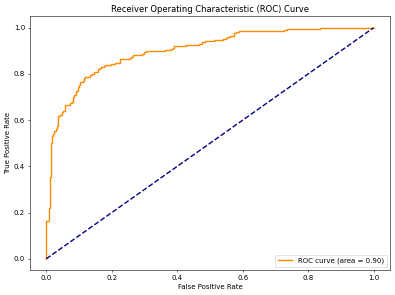

In [19]:
utils.getAUCCurve(df=ana_df,name=f"{KEY}_roc_curve")

# **Analyzing the results (Verbal and All)**

In [20]:
src_df=pd.read_csv("../data/substance_interactions.csv")
src_df.head()

,PREDICATION_ID,PMID,PREDICATE,INDICATOR_TYPE,PREDICATE_START_INDEX,PREDICATE_END_INDEX,SUBJECT_TEXT,SUBJECT_SEMTYPE,SUBJECT_START_INDEX,SUBJECT_END_INDEX,...,OBJECT_START_INDEX,OBJECT_END_INDEX,OBJECT_SCORE,OBJECT_DIST,OBJECT_MAXDIST,OBJECT_CUI,OBJECT_NOVELTY,TYPE,SENTENCE,LABEL
0,P3100,6499897,INTERACTS_WITH,NOM,1298,1304,SA,orch,1235,1237,...,1329,1332,1000,2,2,C0004057,1,ab,"Nor did administration of SA, diflunisal or AS...",n
1,P3101,8369307,INHIBITS,VERB,890,899,rHF,aapp,785,788,...,912,919,888,1,15,C0242417,1,ab,A comparative study of recombinant L-cha...,n
2,P3102,3711333,INHIBITS,VERB,1527,1534,alkaloids,orch,1508,1517,...,1541,1550,1000,1,1,C0003805,1,ab,These findings suggest that some nicotinic alk...,y
3,P3103,11742534,INTERACTS_WITH,NOM,746,753,amino acids,aapp,703,714,...,741,745,694,0,4,C0169658|3716,1,ab,With a truncated chimaeric IL-5Rbeta-gp1...,y
4,P3104,244385,STIMULATES,ADJ,410,419,Neutral endopeptidase,aapp,374,401,...,480,491,1000,3,5,C0039815,1,ab,"Neutral endopeptidase, a zinc-dependent ...",n


In [21]:
joined_df = ana_df.merge(src_df, left_on='id', right_on='PREDICATION_ID', how='inner')
print(joined_df.shape)
print(joined_df.columns)

(600, 32)
Index(['id', 'y_true', 'y_pred', 'y_pred_0', 'y_pred_1', 'PREDICATION_ID',
       'PMID', 'PREDICATE', 'INDICATOR_TYPE', 'PREDICATE_START_INDEX',
       'PREDICATE_END_INDEX', 'SUBJECT_TEXT', 'SUBJECT_SEMTYPE',
       'SUBJECT_START_INDEX', 'SUBJECT_END_INDEX', 'SUBJECT_SCORE',
       'SUBJECT_DIST', 'SUBJECT_MAXDIST', 'SUBJECT_CUI', 'SUBJECT_NOVELTY',
       'OBJECT_TEXT', 'OBJECT_SEMTYPE', 'OBJECT_START_INDEX',
       'OBJECT_END_INDEX', 'OBJECT_SCORE', 'OBJECT_DIST', 'OBJECT_MAXDIST',
       'OBJECT_CUI', 'OBJECT_NOVELTY', 'TYPE', 'SENTENCE', 'LABEL'],
      dtype='object')


**Impact of Argument distance on various performance matrices**

In [22]:
joined_df_verb=joined_df[joined_df["INDICATOR_TYPE"]=="VERB"]
print(joined_df_verb.shape)


(159, 32)


In [23]:
#getting relevant columns
joined_df_verb= joined_df_verb[['id', 'y_true', 'y_pred', 'y_pred_0', 'y_pred_1','SUBJECT_DIST', 'SUBJECT_MAXDIST','OBJECT_DIST', 'OBJECT_MAXDIST']]
joined_df_verb.head()

,id,y_true,y_pred,y_pred_0,y_pred_1,SUBJECT_DIST,SUBJECT_MAXDIST,OBJECT_DIST,OBJECT_MAXDIST
0,P4272,1,1,0.075781,0.924219,1,3,1,2
3,P4045,1,1,0.045938,0.954062,1,5,1,2
12,P4210,1,1,0.036748,0.963252,1,3,1,1
15,P6019,1,1,0.409213,0.590787,1,1,2,3
22,P4564,0,1,0.312390,0.687610,3,5,1,5


In [55]:
import importlib
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [24]:
# cumulative argument distance
joined_df_verb['DIST_SUM'] = joined_df_verb['SUBJECT_DIST'] + joined_df_verb['OBJECT_DIST']

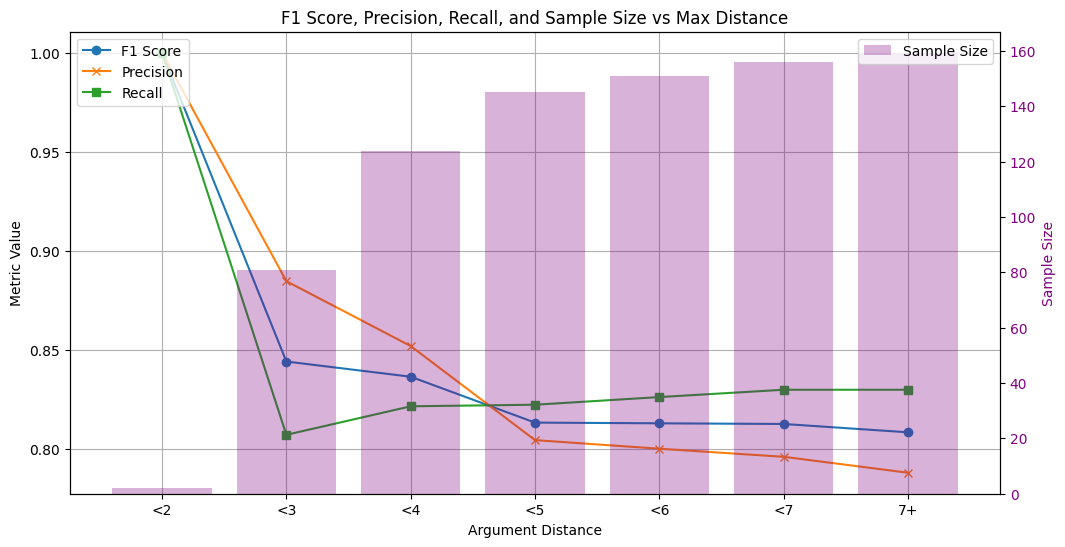

In [25]:
utils.getCumArgDistImpact(df=joined_df_verb, name=f"{KEY}_cum_arg_dist_impact_verbal")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


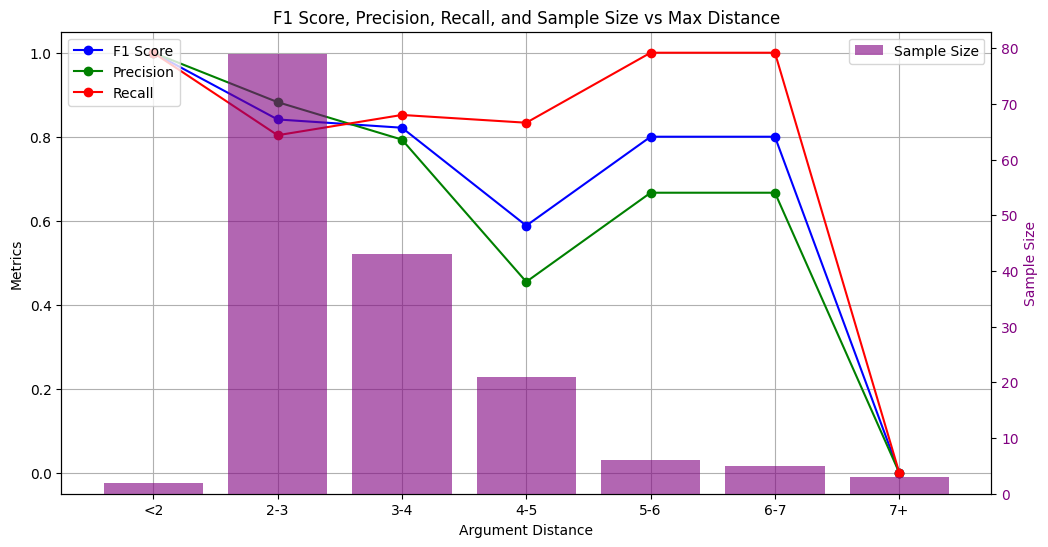

In [26]:
utils.getCatArgDistImpact(df=joined_df_verb, name=f"{KEY}_cat_arg_dist_impact_verbal")

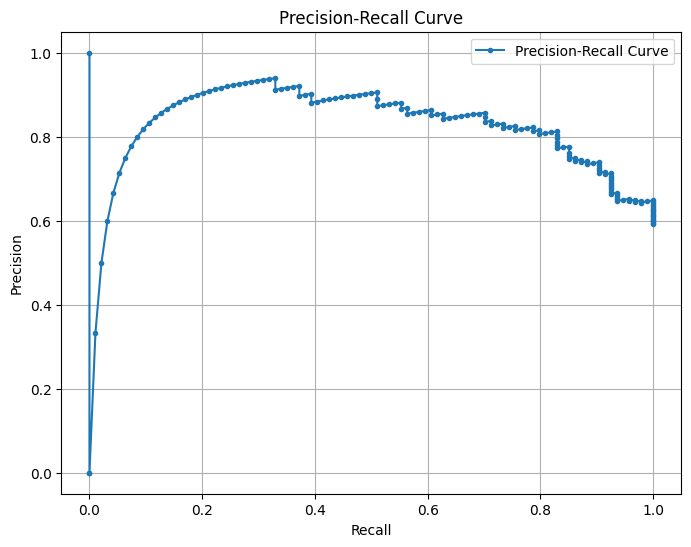

In [27]:
utils.getPrecisionRecallCurve(df=joined_df_verb, name=f"{KEY}_precision_recall_curve_verbal")

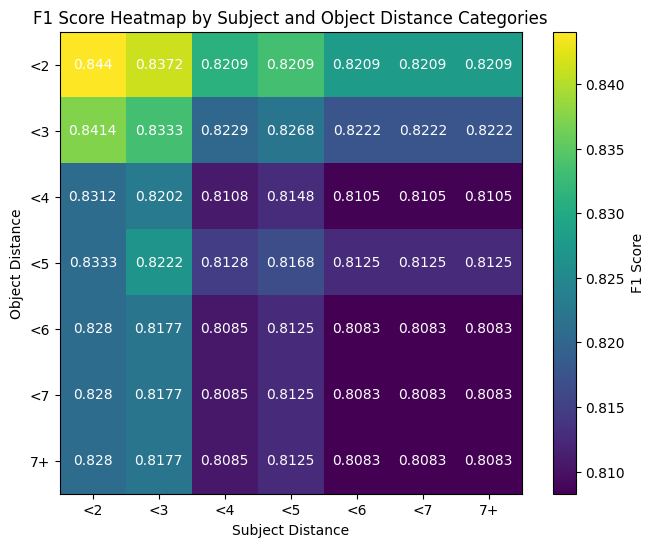

In [28]:
utils.getSubObjHeatmap(df=joined_df_verb,name=f"{KEY}_sub_obj_heatmap_verbal")

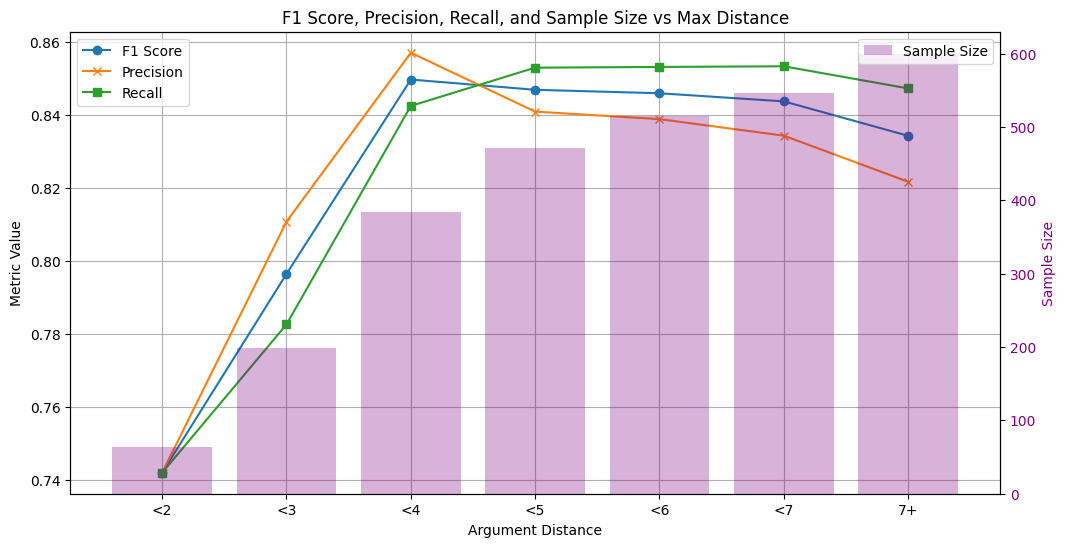

In [29]:
joined_df['DIST_SUM'] = joined_df['SUBJECT_DIST'] + joined_df['OBJECT_DIST']
utils.getCumArgDistImpact(df=joined_df, name=f"{KEY}_cum_arg_dis_impact_all")

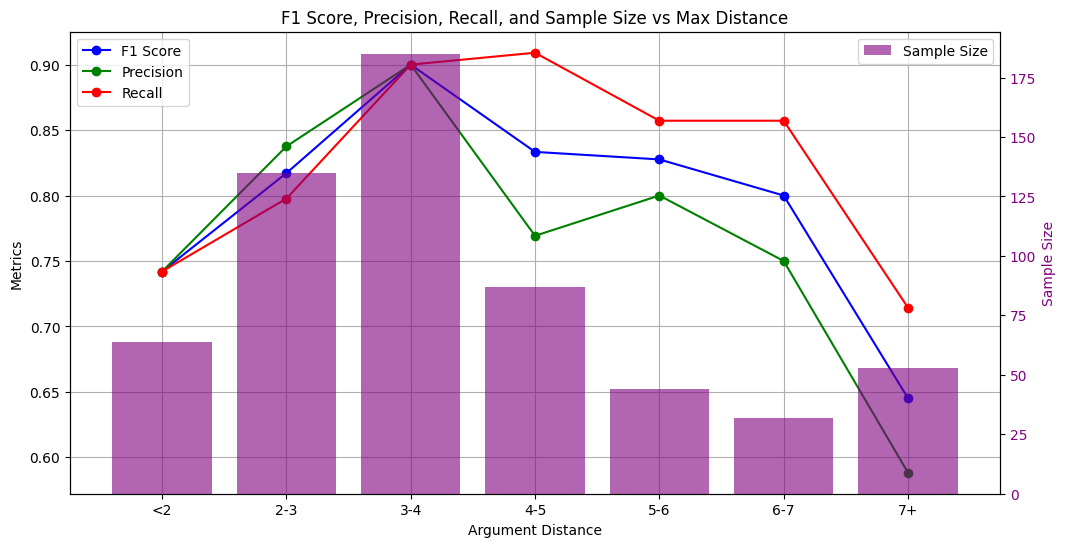

In [30]:
utils.getCatArgDistImpact(df=joined_df, name=f"{KEY}_cat_arg_dis_impact_all")

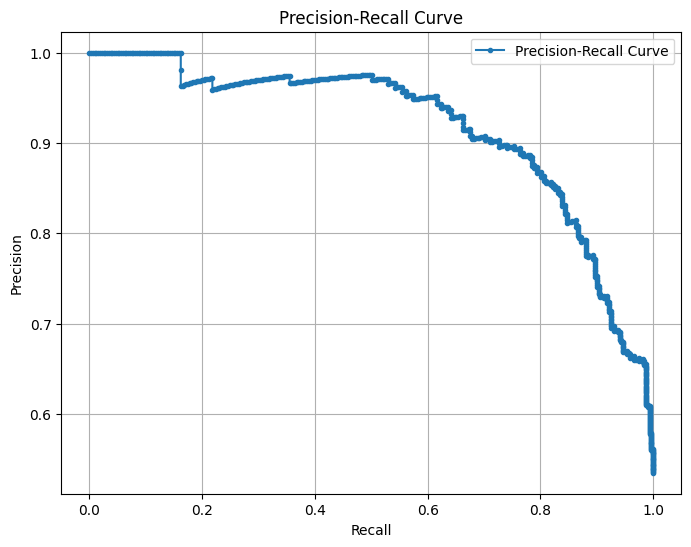

In [31]:
utils.getPrecisionRecallCurve(df=joined_df, name=f"{KEY}_precision_recall_curve_all")

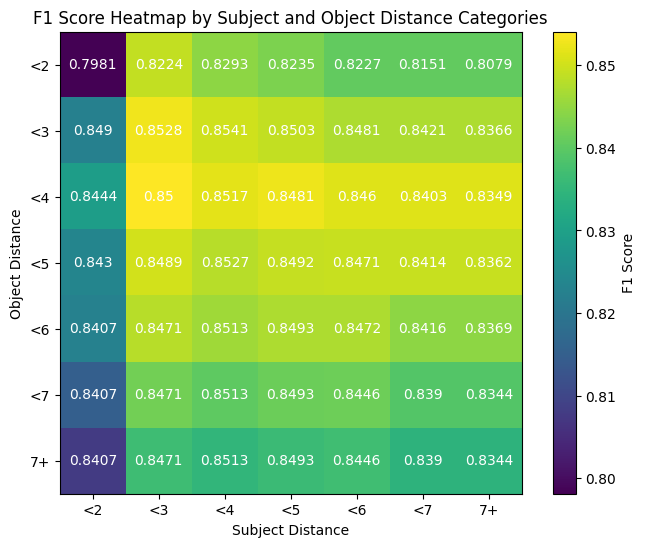

In [32]:
utils.getSubObjHeatmap(df=joined_df, name=f"{KEY}_sub_obj_heatmap_all")